<a href="https://colab.research.google.com/github/hila-chefer/TargetCLIP/blob/main/TargetCLIP%2Be4e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# e4e setup, run once only!

In [1]:
#@title Setup (may take a few minutes)
import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'

%tensorflow_version 1.x
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 

!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.

%load_ext autoreload
%autoreload 2

TensorFlow 1.x selected.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 41.5 MB/s eta 0:00:08tcmalloc: large alloc 1147494400 bytes == 0x56010e6ca000 @  0x7f588b8bd615 0x5600d5f274cc 0x5600d600747a 0x5600d5f2a2ed 0x5600d601be1d 0x5600d5f9de99 0x5600d5f989ee 0x5600d5f2bbda 0x5600d5f9dd00 0x5600d5f989ee 0x5600d5f2bbda 0x5600d5f9a737 0x5600d601cc66 0x5600d5f99daf 0x5600d601cc66 0x5600d5f99daf 0x5600d601cc66 0x5600d5f99daf 0x5600d5f2c039 0x5600d5f6f409 0x5600d5f2ac52 0x5600d5f9dc25 0x5600d5f989ee 0x5600d5f2bbda 0x5600d5f9a737 0x5600d5f989ee 0x5600d5f2bbda 0x5600d5f99915 0x5600d5f2bafa 0x5600d5f99c0d 0x5600d5f989ee
     |█████████████████████████████▏  | 1055.7 MB 1.5 MB/s eta 0:01:08tcmalloc: large alloc 1434370048 bytes == 0x560152d20000 @  0x7f588b8bd615 0x5600d5f274cc 0x5600d600747a 0x5600d5f2a2ed 0x5600d601be1d 0x5600d5f9de99 0x5600d5f989ee 0x5600d5f2bbda 0x5600d5f9dd00 0x5600d5f989ee 0x5600d5f2bbda 0x5600d5f9a737 0

In [2]:
#@title Download e4e model
experiment_type = 'ffhq_encode'
def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory pretrained_models. """
    current_directory = os.getcwd()
    save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url    

MODEL_PATHS = {
    "ffhq_encode": {"id": "1cUv_reLE6k3604or78EranS7XzuVMWeO", "name": "e4e_ffhq_encode.pt"},
    "cars_encode": {"id": "17faPqBce2m1AQeLCLHUVXaDfxMRU2QcV", "name": "e4e_cars_encode.pt"},
    "horse_encode": {"id": "1TkLLnuX86B_BMo2ocYD0kX9kWh53rUVX", "name": "e4e_horse_encode.pt"},
    "church_encode": {"id": "1-L0ZdnQLwtdy6-A_Ccgq5uNJGTqE7qBa", "name": "e4e_church_encode.pt"}
}

path = MODEL_PATHS[experiment_type]
download_command = get_download_model_command(file_id=path["id"], file_name=path["name"]) 

!wget {download_command}

--2021-11-02 20:06:41--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2021-11-02 20:06:41--  https://docs.google.com/uc?export=download&confirm=&id=1cUv_reLE6k3604or78EranS7XzuVMWeO
Resolving docs.google.com (docs.google.com)... 173.194.74.113, 173.194.74.102, 173.194.74.100, ...
Connecting to docs.google.com (docs.google.com)|173.194.74.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/content/encoder4editing/pretrained_models/e4e_ffhq_encode.pt’

/content/encoder4ed     [ <=>                ]   3.05K  --.-KB/s    in 0s      

2021-11-02 20:06:41 (31.1 MB/s) - ‘/content/encoder4editing/pretrained_models/e4e_ffhq_encode.pt’ saved [3127]

FINISHED --2021-11-02 20:06:41--
Total wall clock time: 0.2s
Downloaded: 1 files, 3.1K in 0s (31.1 MB/s)


In [3]:
#@markdown Upload an image to the encoder4editing folder and set the image_name into the image name
image_name = '/content/encoder4editing/me.jpeg' #@param {type:"string"}
os.chdir('/content/encoder4editing')
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/e4e_ffhq_encode.pt",
        "image_path": image_name
    }
    
}
# Setup required image transformations
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]
if experiment_type == 'cars_encode':
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
            transforms.Resize((192, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 192)
else:
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 256)

In [4]:
#@title e4e setup
#@ e4e setup 
from gdown import download as drive_download
drive_download("https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P", "/content/encoder4editing/e4e_ffhq_encode.pt", quiet=False)
experiment_type = 'ffhq_encode'

os.chdir('/content/encoder4editing')

EXPERIMENT_ARGS = {
        "model_path": "e4e_ffhq_encode.pt"
    }
EXPERIMENT_ARGS['transform'] = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
resize_dims = (256, 256)

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Downloading...
From: https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P
To: /content/encoder4editing/e4e_ffhq_encode.pt
100%|██████████| 1.20G/1.20G [00:07<00:00, 172MB/s]


Loading e4e over the pSp framework from checkpoint: e4e_ffhq_encode.pt
Model successfully loaded!


--2021-11-02 20:08:06--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  65.1MB/s    in 0.9s    

2021-11-02 20:08:07 (65.1 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

Aligned image has shape: (256, 256)


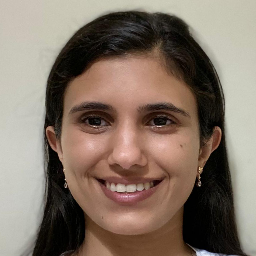

In [6]:
#@title Show original image
image_path = EXPERIMENT_DATA_ARGS[experiment_type]["image_path"]
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

Inference took 0.7413 seconds.


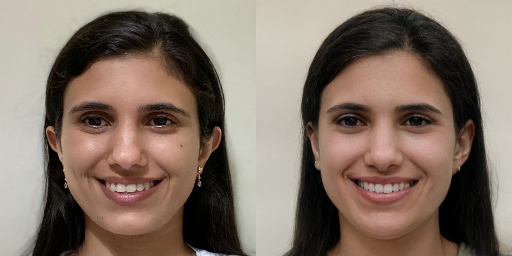

In [7]:
#@title Invert
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

with torch.no_grad():
    tic = time.time()
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)

## TargetCLIP Setup 

In [8]:
import os
!git clone https://github.com/hila-chefer/TargetCLIP
os.chdir(f'./TargetCLIP')

Cloning into 'TargetCLIP'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (267/267), done.
remote: Compressing objects: 100% (253/253), done.
remote: Total 267 (delta 110), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (267/267), 23.18 MiB | 20.57 MiB/s, done.
Resolving deltas: 100% (110/110), done.


In [9]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads StyleGAN's weights
ids = ['1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

     |████████████████████████████████| 64 kB 1.8 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=6b4b765a9e7c31c1846ff809af58b1e156e40059b20a8489b22aa3ec41205fe1
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3s3fncaq
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-3s3fncaq
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369090 sha256=5ecae7df965e64321351f36fe6184fc1ab75dd6a9c3c0832859d3ed5f58cc872
  Stored in directory: /tmp/pip-ephem-wheel-cache-5cvkqp6w/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [10]:
import argparse
import os
os.chdir(f'../TargetCLIP')
import numpy as np
import torch
import torchvision
from torch import optim
from tqdm import tqdm
import clip
# from criteria.clip_loss import CLIPLoss
from models.stylegan2.model import Generator
import math
import copy

In [11]:
#@title Aux functions
def get_latent(args, g_ema):
    mean_latent = g_ema.mean_latent(4096)
    latent_code_init_not_trunc = torch.randn(1, 512).cuda()
    with torch.no_grad():
        # _, latent_code_init = g_ema([latent_code_init_not_trunc], return_latents=True,
        #                             truncation=args.truncation, truncation_latent=mean_latent)
        _, latent_code_init,_ = g_ema([latent_code_init_not_trunc], return_latents=True,
                                    truncation=args.truncation, truncation_latent=mean_latent)

    direction = latent_code_init.detach().clone()
    direction.requires_grad = True
    return direction


def load_model(args):
    g_ema = Generator(args.stylegan_size, 512, 8)
    g_ema.load_state_dict(torch.load(args.ckpt)["g_ema"], strict=False)
    g_ema.eval()
    g_ema = g_ema.cuda()
    return g_ema


def get_lr(t, initial_lr, rampdown=0.75, rampup=0.005):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp

args = {
    "ckpt": "stylegan2-ffhq-config-f.pt",
    "stylegan_size": 1024,
    "lr": 0.1,
    "truncation": 0.7,
    "save_intermediate_image_every": 1,
    "results_dir": "results",
    "dir_name": "results",
    "num_batches": 1,
    "real_images": True,
    "data_path": "train_faces.pt",
}

from argparse import Namespace
a=Namespace(**args)

g_ema = load_model(a)


In [22]:
#@title Chose target

dirs = {
  'Elsa': 'dirs/elsa.npy',
  'Pocahontas': 'dirs/pocahontas.npy',
  'Keanu Reeves': 'dirs/keanu.npy',
  'Trump': 'dirs/trump.npy',
  'Joker': 'dirs/joker.npy',
  'Ariel': 'dirs/ariel.npy',
  'Doc Brown': 'dirs/doc.npy',
  'Beyonce': 'dirs/beyonce.npy',
  'Morgan Freeman': 'dirs/morgan.npy',
  'Avatar': 'dirs/avatar.npy',
  'Wolverine': 'dirs/wolverine.npy',
  'Gargamel': 'dirs/gargamel.npy',
}

targets = {
  'Elsa': 'dirs/targets/elsa.jpg',   
  'Pocahontas': 'dirs/targets/pocahontas.jpg',
  'Keanu Reeves': 'dirs/targets/keanu.jpg',
  'Trump': 'dirs/targets/trump.jpg',
  'Joker': 'dirs/targets/joker.jpg',
  'Ariel': 'dirs/targets/ariel.jpeg',
  'Doc Brown': 'dirs/targets/doc_brown.jpg',
  'Beyonce': 'dirs/targets/beyonce.jpg',
  'Morgan Freeman': 'dirs/targets/morgan_freeman.jpg',
  'Avatar': 'dirs/targets/avatar.jpg',
  'Wolverine': 'dirs/targets/wolverine.jpg',
  'Gargamel': 'dirs/targets/Gargamel.png',
}

sources_ids = {
  'Taylor Swift': 67,   
  'Elon Musk': 4,
  'Hillary Clinton': 9,
  'Alfie Allen': 34,
  'Obama': 61
}

target = 'Beyonce' #@param ['Trump','Keanu Reeves', 'Elsa', 'Pocahontas', 'Joker', 'Ariel', 'Doc Brown', 'Beyonce', 'Morgan Freeman', 'Avatar', 'Wolverine', 'Gargamel']
source = latents
dir = torch.from_numpy(np.load(dirs[target]))
target_path = targets[target]

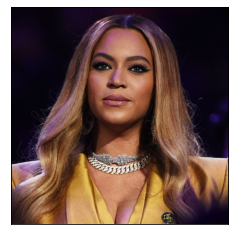

In [23]:
#@title Show target image
assert(target_path is not None)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(target_path)
imgplot = plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

(-0.5, 1023.5, 1023.5, -0.5)

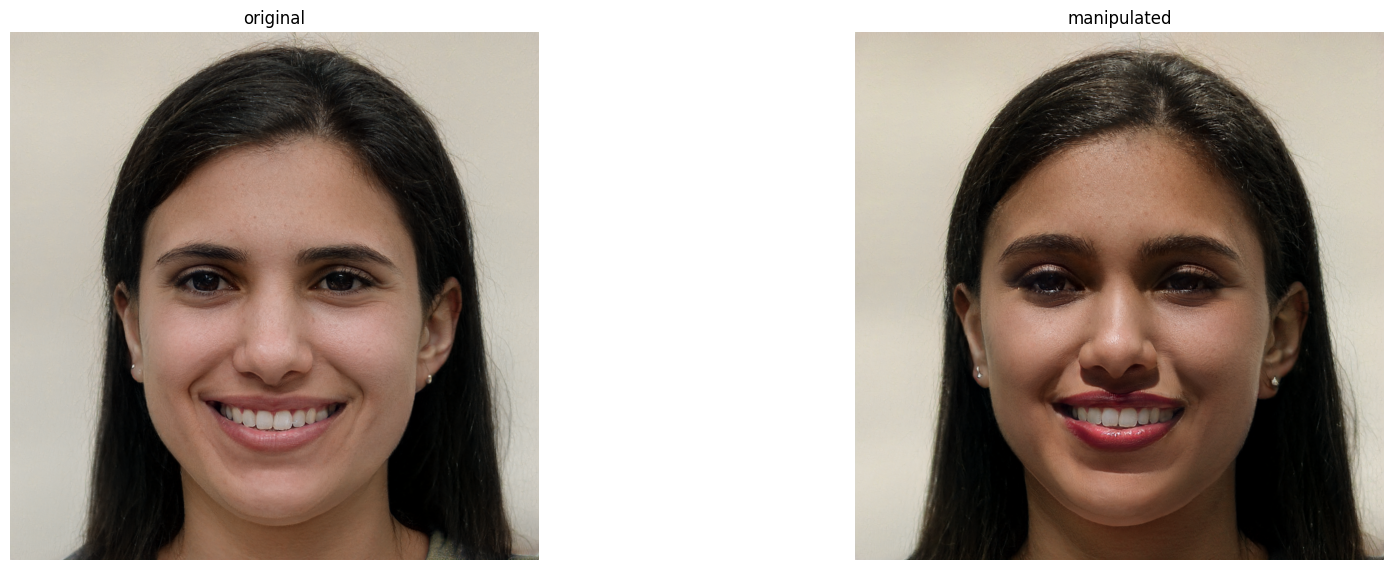

In [24]:
#@title Show manipulation on source
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#alpha=1
alpha = 0.5 #@param {type:"slider", min:0, max:2, step:0.1}
dir = dir.cuda()
source = source.cuda()
source_img, _ = g_ema([source], input_is_latent=True, randomize_noise=False)
source_amp, _ = g_ema([source + dir * alpha], input_is_latent=True,
                        randomize_noise=False)

torchvision.utils.save_image(source_img, f"results_orig.png", normalize=True, range=(-1, 1))
torchvision.utils.save_image(source_amp, f"results_manipulated.png", normalize=True, range=(-1, 1))
plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(mpimg.imread('results_orig.png'))
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mpimg.imread('results_manipulated.png'))
plt.title('manipulated')
plt.axis('off')